* [1. Анализ исходных данных](#1)<a id='main'></a>
    * [1.1 Обработка выбросов](#1.1)
    * [1.2 Категориальные признаки](#1.2)
    * [1.3 Корректировка "подозрительных" значений](#1.3)
    * [1.4 Обработка null значений](#1.4)
    * [1.5 Поиск новых признаков](#1.5)
* [2. Построение модели](#2)<a id='main'>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score


In [2]:
for_model_csv = 'train.csv'
for_predict_csv = 'test.csv'

In [3]:
df_train = pd.read_csv(for_model_csv)
df_for_predict = pd.read_csv(for_predict_csv)

## 1. Анализ исходных данных<a id='1'>
    
[Оглавление](#main)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Как видно, null значения содержатся только в колонках `Healthcare_1` (причем здесь порядка половины значений не определены) и `LifeSquare`, а колонками не числового типа являются `Ecology_2`, `Ecology_3` и `Shops_2`.

### 1.1 Обработка выбросов<a id='1.1'>
    
[Оглавление](#main)

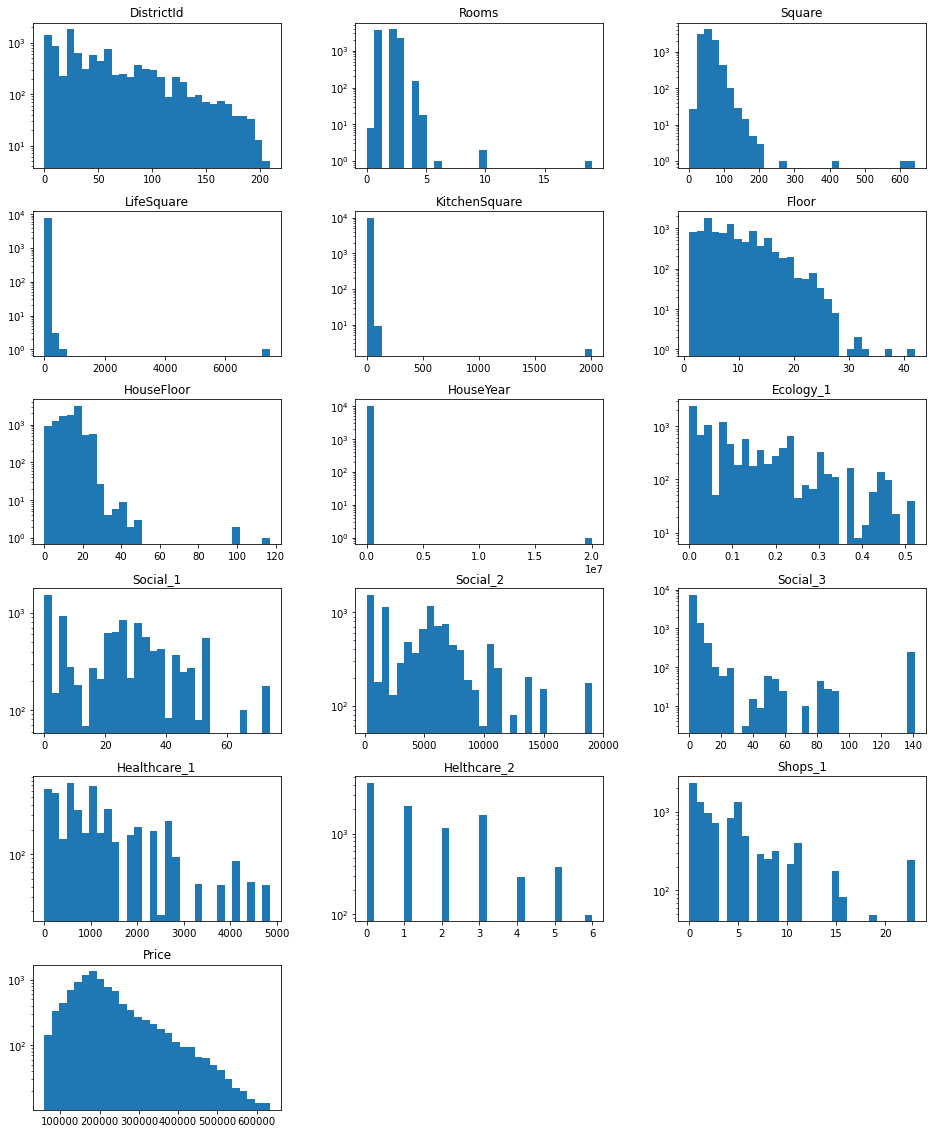

In [5]:
df_train.drop(columns=['Id']).hist(figsize=(16,20), bins=30, grid=False, log=True, layout=(-1, 3));

In [6]:
def group_by_feature(feature, df=df_train, dropna=True):
    """
    Группировка исходной выборки по выбранному полю с отклонением от общей цены
    """
    df_gr = df.groupby(by=feature, dropna=True)[['Price']].agg(['count', 'median', 'mean', 'std'])
    df_gr.reset_index(col_level=0, inplace=True)
    df_gr['median dif, %'] = (df_gr['Price']['median'] - df_train['Price'].median()) / df_train['Price'].median() * 100
    df_gr['mean dif, %'] = (df_gr['Price']['mean'] - df_train['Price'].mean()) / df_train['Price'].mean() * 100
    df_gr['std, %'] = df_gr['Price']['std'] / df_train['Price'].mean() * 100
    return df_gr

In [7]:
group_by_feature('Rooms')

Rooms Price                                              median dif, %  \
        count         median           mean            std                 
0   0.0     8  214937.068787  200435.886261   69072.158402     11.789393   
1   1.0  3705  154979.497993  159850.800729   51892.475206    -19.394714   
2   2.0  3880  200320.754636  215256.306416   73452.209126      4.187406   
3   3.0  2235  268723.157677  289337.962452  104456.463546     39.763694   
4   4.0   150  377524.231990  383251.100956  117182.111674     96.351448   
5   5.0    18  455355.638212  410431.605679  134576.702777    136.831788   
6   6.0     1  229661.964416  229661.964416            NaN     19.447854   
7  10.0     2  244797.297328  244797.297328  102485.265864     27.319784   
8  19.0     1   78364.616704   78364.616704            NaN    -59.242336   

  mean dif, %     std, %  
                          
0   -6.399105  32.255780  
1  -25.351801  24.233096  
2    0.521834  34.301205  
3   35.116982  48.779780  
4   78.973170  54.722489  
5   91.666104  62.845531  
6    7.249085        NaN  
7   14.317084  47.859257  
8  -63.404766        NaN

In [8]:
group_by_feature('Floor')

Floor Price                                              median dif, %  \
         count         median           mean            std                 
0      1   235  169061.669560  181197.129047   70926.570019    -12.070535   
1      2   588  183601.304365  200054.515039   88289.786338     -4.508429   
2      3   872  180522.397155  197058.565017   85973.425575     -6.109778   
3      4   949  189341.908219  206755.158571   89018.466784     -1.522724   
4      5   876  190227.249964  208642.097899   86730.114895     -1.062256   
5      6   802  189412.316654  213620.817491   91476.980816     -1.486105   
6      7   759  197245.267664  219149.530324   97808.427550      2.587836   
7      8   643  198819.511617  217291.383083   87884.414517      3.406605   
8      9   604  195029.868979  218588.232587   95045.510993      1.435601   
9     10   553  196250.492789  212030.108560   83523.511653      2.070451   
10    11   457  195507.880289  213094.735844   84328.781249      1.684216   
11    12   438  190217.223931  211672.926703   95125.869071     -1.067470   
12    13   398  199259.147396  215104.664305   82909.412084      3.635261   
13    14   362  199486.489638  231031.896587  100870.070749      3.753502   
14    15   287  203190.650926  234276.528574  103016.856420      5.680047   
15    16   290  191316.391017  222327.410321  102149.938705     -0.495790   
16    17   256  199517.589213  219896.414764   96466.127369      3.769677   
17    18   185  192358.950694  230055.477403  107443.747062      0.046448   
18    19   121  198981.146135  229093.752512  106664.630088      3.490671   
19    20    68  229457.910127  244087.213465  107541.039877     19.341725   
20    21    59  215912.557642  243138.009099  102335.460126     12.296748   
21    22    54  279761.392940  289708.585988  114828.298825     45.504712   
22    23    25  260960.450895  277347.739049  125056.532764     35.726287   
23    24    53  245736.934369  262331.096642  124198.880068     27.808492   
24    25    34  217451.998567  270813.232998  114635.551306     13.097415   
25    26    18  276618.475193  313255.149648  118554.271884     43.870071   
26    27     5  211498.637627  238152.827407  141325.034229     10.001055   
27    28     3  333862.631152  310932.492847  184885.610471     73.642923   
28    31     1  117647.461002  117647.461002            NaN    -38.811214   
29    32     2  245640.188762  245640.188762  209528.952221     27.758175   
30    33     1  389554.063540  389554.063540            NaN    102.608198   
31    37     1  269113.584248  269113.584248            NaN     39.966756   
32    42     1  411691.504766  411691.504766            NaN    114.121946   

   mean dif, %     std, %  
                           
0   -15.383349  33.121765  
1    -6.577201  41.230157  
2    -7.976270  40.148447  
3    -3.448089  41.570441  
4    -2.566914  40.501811  
5    -0.241918  42.718534  
6     2.339918  45.675236  
7     1.472188  41.040853  
8     2.077799  44.384990  
9    -0.984758  39.004370  
10   -0.487591  39.380420  
11   -1.151557  44.422516  
12    0.451019  38.717593  
13    7.888825  47.104982  
14    9.404025  48.107503  
15    3.823945  47.702664  
16    2.688703  45.048399  
17    7.432850  50.174802  
18    6.983737  49.810964  
19   13.985484  50.220236  
20   13.542218  47.789300  
21   35.290059  53.623289  
22   29.517708  58.399739  
23   22.505135  57.999226  
24   26.466180  53.533279  
25   46.285991  55.363269  
26   11.214205  65.996912  
27   45.201341  86.339123  
28  -45.060200        NaN  
29   14.710703  97.847236  
30   81.916570        NaN  
31   25.672467        NaN  
32   92.254460        NaN

Четко видна тенденция, что стоимость жилья увеличивается при увеличении этажа, на котором находится квартира, причем примерно до 26-28, а т.к. после 28 количество продаваемых квартир мало, заменим их в дальнейшем модой.

In [9]:
group_by_feature('HouseFloor')

HouseFloor Price                                               \
              count         median           mean            std   
0         0.0   269  177511.314827  204397.970231  103926.618483   
1         1.0   497  185338.851196  210420.432070  101592.750885   
2         2.0    48  189213.624996  194467.463449   74333.784102   
3         3.0   127  153946.777452  176652.101112   96136.561383   
4         4.0   134  131536.878104  151286.889742   78548.781447   
5         5.0  1031  183678.608176  198760.094104   72580.382693   
6         6.0    58  221483.898300  254037.507036  133151.737994   
7         7.0    59  270475.653807  282340.913443  129046.139022   
8         8.0   141  292466.107130  310717.333793  128959.083423   
9         9.0  1389  196713.117120  205671.685200   72011.147960   
10       10.0   135  217232.114341  249284.579609  116327.166071   
11       11.0    28  216613.441773  255475.395565  148168.901770   
12       12.0  1074  198341.436249  207581.566731   70402.144107   
13       13.0    27  247611.338011  269808.869597  115043.842265   
14       14.0   625  204667.927606  228735.010796   89502.516433   
15       15.0   123  176193.075464  201156.018676  103699.026671   
16       16.0   576  228473.107922  246401.079977   96061.970193   
17       17.0  2331  182824.309938  200846.238445   86075.051650   
18       18.0    89  187042.020422  228426.354875  119822.533127   
19       19.0   108  145360.092451  179433.629840   90553.105031   
20       20.0   105  207032.139195  235022.735795  109704.185621   
21       21.0    33  283099.049677  305127.093448  133153.115016   
22       22.0   343  234885.527186  254145.448416  114434.783311   
23       23.0    40  323768.273031  326630.692549  101260.330973   
24       24.0   176  216384.336930  251162.190732  104879.997481   
25       25.0   374  178259.575862  205644.073077   95553.844303   
26       26.0     1  244668.613410  244668.613410            NaN   
27       27.0     6  302369.684687  291783.959020  171694.535164   
28       28.0     3  231963.869232  248459.724788  111564.353596   
29       29.0     1  131477.022922  131477.022922            NaN   
30       30.0    21  343821.934744  354135.918321  123972.431070   
31       31.0     1  287326.123905  287326.123905            NaN   
32       32.0     4  188622.046116  175558.742946   63260.414500   
33       36.0     1  342223.033781  342223.033781            NaN   
34       37.0     4  281171.257975  285613.082870  135112.908708   
35       38.0     1  269113.584248  269113.584248            NaN   
36       39.0     2  335364.930260  335364.930260  200081.537767   
37       40.0     7  521829.550445  499438.961487   88207.619713   
38       44.0     1  117647.461002  117647.461002            NaN   
39       45.0     1  213171.135199  213171.135199            NaN   
40       47.0     1  450706.552655  450706.552655            NaN   
41       48.0     2  295544.012900  295544.012900  164257.358232   
42       99.0     2  269728.514047  269728.514047   37333.260224   
43      117.0     1  207248.370520  207248.370520            NaN   

   median dif, % mean dif, %     std, %  
                                         
0      -7.675850   -4.548865  48.532349  
1      -3.604726   -1.736455  47.442464  
2      -1.589445   -9.186279  34.712889  
3     -19.931835  -17.505817  44.894496  
4     -31.587288  -29.351033  36.681237  
5      -4.468223   -7.181678  33.894074  
6      15.194418   18.632139  62.180092  
7      40.675172   31.849454  60.262832  
8      52.112471   45.100865  60.222178  
9       2.311063   -3.954057  33.628249  
10     12.983053   16.412585  54.323240  
11     12.661279   19.303614  69.192908  
12      3.157956   -3.062168  32.876865  
13     28.783375   25.997156  53.723945  
14      6.448383    6.816210  41.796485  
15     -8.361470   -6.062813  48.426067  
16     18.829526   15.066029  44.859663  
17     -4.912546   -6.207476  40.195905  
18     -2.718903    6.672071  55.9

Бросающейся в глаза корреляции нет, однако есть немногочисленные выбосы со значениями 99 и 117. Менять все редкие значения выше ~26 нельзя, т.к. достаточно часто можно встретить достаточно высокие дома с количеством этажей кратным 10 (30, 40), ох уж это стремление к красивым числам

Применим эти корректировки, а также преобразуем группы, которые включают менее 10 элементов (0.1% выборки)

In [10]:
def outliers_handling(origin_df, train_df=False):
    """
    Обработка выбросов
    """
    if type(train_df) == bool:
        train_df = origin_df
    
    origin_df.loc[df_train['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].mode()[0]
    origin_df.loc[df_train['Rooms'] == 0, 'Rooms'] = train_df['Rooms'].mode()[0]
    origin_df.loc[df_train['Floor'] > 28, 'Floor'] = train_df['Floor'].mode()[0]
    origin_df.loc[df_train['HouseFloor'] > 50, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

    origin_df.loc[df_train['Square'] > 250, 'Square'] = train_df['Square'].median()
    origin_df.loc[df_train['LifeSquare'] > 250, 'LifeSquare'] = train_df['LifeSquare'].median()
    origin_df.loc[df_train['KitchenSquare'] > 100, 'KitchenSquare'] = train_df['KitchenSquare'].median()
    origin_df.loc[df_train['HouseYear'] > datetime.now().year, 'HouseYear'] = datetime.now().year
    
    return origin_df

df_train = outliers_handling(df_train)

### 1.2 Категориальные признаки:<a id='1.2'>
    
[Оглавление](#main)

In [11]:
group_by_feature('Ecology_2')

Ecology_2 Price                                             median dif, %  \
            count         median           mean           std                 
0         A    97  182516.558181  193139.717006  60567.319120     -5.072609   
1         B  9903  192371.633485  214344.544223  93111.915868      0.053045   

  mean dif, %     std, %  
                          
0   -9.806319  28.284133  
1    0.096053  43.482027

In [12]:
group_by_feature('Ecology_3')

Ecology_3 Price                                             median dif, %  \
            count         median           mean           std                 
0         A   275  211889.942902  243179.560704  99244.291969     10.204574   
1         B  9725  191668.400065  213317.654992  92558.795271     -0.312709   

  mean dif, %     std, %  
                          
0   13.561622  46.345765  
1   -0.383491  43.223727

In [13]:
group_by_feature('Shops_2')

Shops_2 Price                                             median dif, %  \
          count         median           mean           std                 
0       A   825  181620.004130  192339.700513  67201.979309     -5.538909   
1       B  9175  193446.129454  216098.999571  94597.606004      0.611893   

  mean dif, %     std, %  
                          
0  -10.179917  31.382431  
1    0.915360  44.175825

Как видно, все эти категории содержат по 2 значения, можно заменить их на бинарные. Также значения сильно не сбалансированные, но меньшая группа имеет средние цены на жилье от 10% отличные от средних в целом, а значит признаки имеет смысл оставить

In [14]:
def category_transform(origin_df):
    """
    Обработка категориальных признаков
    """
    cat_col = origin_df[origin_df.dtypes[origin_df.dtypes =='object'].keys()].replace(['A', 'B'], [0, 1])
    origin_df[origin_df.dtypes[origin_df.dtypes =='object'].keys()] = cat_col
    return origin_df

df_train = category_transform(df_train)

### 1.3 Корректировка "подозрительных" значений<a id='1.3'>
    
[Оглавление](#main)

In [15]:
df_train.drop('Id', axis=1).describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.888400,56.143696,36.047053,5.843200,8.508400,12.583000,1984.872600,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,0.917500,214138.857399
std,43.587592,0.811056,19.023477,17.826946,4.810897,5.202676,6.583027,18.416734,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,0.275139,92872.293865
min,0.000000,1.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1910.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1974.000000,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513040,32.781260,6.000000,7.000000,13.000000,1977.000000,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879
75%,75.000000,2.000000,65.889256,45.099772,9.000000,12.000000,17.000000,2001.000000,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,1.000000,249135.462171
max,209.000000,5.000000,212.932361,233.949309,96.000000,28.000000,48.000000,2021.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


**Показатели площади: Square, LifeSquare, KitchenSquare**

Видно, что встречаются квартиры с очень малой площадью, предлагается более подробно взглянуть на них, а особенно интересно узнать, есть ли такие дорогие квартиры

In [16]:
df_train.loc[(df_train.Square < 20) & (df_train.Price > df_train.Price.median())]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,1,1,43,8429,3,NaN,3,9,1,412511.088764
3413,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,1,1,16,3433,4,2643.0,4,5,1,369472.403061
8030,13265,1,3.0,4.823679,79.767964,0.0,6,17.0,1977,0.007122,1,1,1,264,0,NaN,0,1,1,237716.681261
8283,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,1,1,53,13670,4,NaN,1,11,1,458378.777006
9294,6782,45,1.0,2.954309,5.257278,1.0,3,1.0,1977,0.195781,1,1,23,5212,6,NaN,3,2,1,438005.182323
9613,7657,38,1.0,4.502784,4.618547,1.0,28,1.0,1977,0.060753,1,1,15,2787,2,520.0,0,7,1,483283.488083


Как видно, их не много, но здесь видна некоторая особенность, что все они построены в 1977 году, что наталкивает на мысль о том, что это или значение по умолчанию (если процент таких вариантов в выборке будет подавляющий), или так могут помечаються квартиры без каких-либо подтвержденных исходных данных (или что-либо в таком духе)

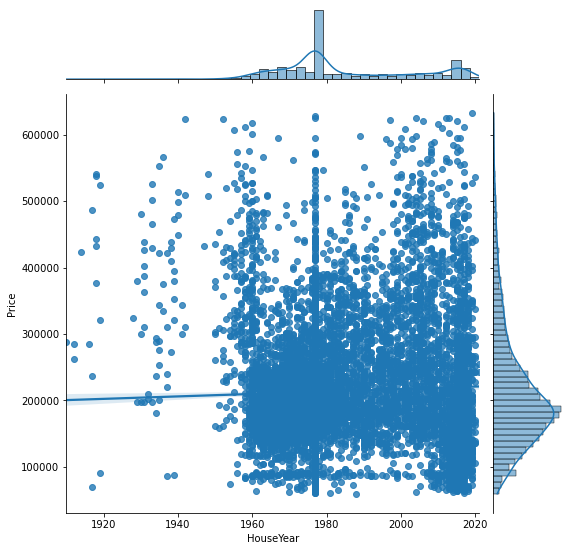

In [17]:
grid = sns.jointplot(x=df_train['HouseYear'], y=df_train['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

Исходя из количества домов 1977 года можно сделать вывод, что это скорее всего значение по умолчанию, которое можно заменить на случайное, начиная с 1960 года. Это можно сделать, так как прямого сильного влияния год постройки на стоимость жилья не оказывает. А также вместе с этим заменим в дальнейшем помещения с чрезмерно низкой площадью на более-менее адеквартную. Изменения отображены далее в `value_correction()`

Максимальная площадь кухни больше максимальной площади квартиры среди всех квартир. Посмотрим, сколько еще таких квартир в выборке и какое их распределение

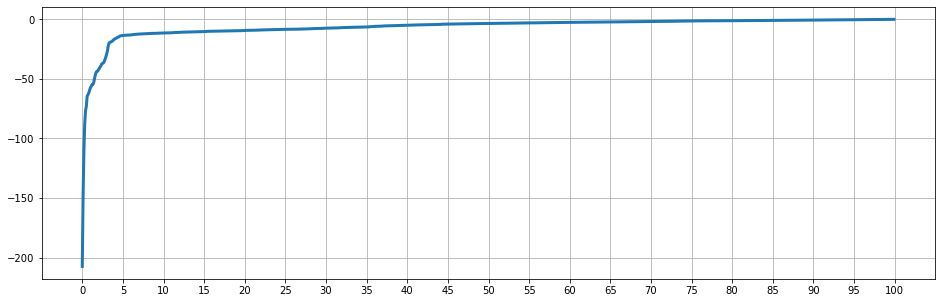

'Общее количество: 840'

In [18]:
sq_dif = df_train['Square'] - df_train['LifeSquare'] - df_train['KitchenSquare']
q = [np.percentile(sq_dif[sq_dif < 0], q=x) for x in np.arange(0, 100, 0.1)]
fig = plt.figure(figsize=(16, 5))
plt.plot(np.arange(0, 100, 0.1), q, linewidth=3)
plt.grid()
plt.xticks(range(0, 101, 5))
plt.show()
'Общее количество: ' + str(sq_dif[sq_dif < 0].size)

В большинстве случаев (более 95%), когда площадь квартиры меньше суммы площадей жилой зоны и кухни, погрешность не превышает 15 м., что дает возможность искусственно высчитать общую площадь квартиры без сильной потери точности. Однако, здесь можно дополнительно ввести условие, что когда кухня больше жилой зоны, то высчитываем сначала ее.

In [19]:
sq_dif = df_train['Square'] - df_train['LifeSquare'] - df_train['KitchenSquare']

df_train.loc[sq_dif < -15][['Square', 'LifeSquare', 'KitchenSquare', 'Price']].sort_values('LifeSquare', ascending=False)

,Square,LifeSquare,KitchenSquare,Price
1982,52.513310,233.949309,26.0,455264.882666
9910,200.334539,201.627361,25.0,528560.506016
1641,174.649522,174.837082,15.0,232766.187698
6332,33.398983,164.153360,6.0,104891.073757
1867,138.980817,138.004600,43.0,169528.896664
343,125.287183,127.477137,19.0,522197.035995
2934,105.443592,107.927859,15.0,250727.263985
2916,97.490674,99.323558,96.0,445074.956552
8370,82.877358,83.783846,15.0,201620.866405
4277,79.130550,83.470011,12.0,405231.600823


Все изменения отображены в `value_correction()` ниже

**Показатели этажности: Floor, HouseFloor**

Проверим, есть ли ситуации, когда этажность здания меньше этажа, на котором расположена квартира 

In [20]:
df_train.loc[df_train['Floor'] - df_train['HouseFloor'] > 0, 'Floor'].size

1825

Таких примеров достаточно много, в связи с чем можно скорректировать этажность здания, но не сам этаж, так как было замечено ранее, сущесвует явная корреляция стоимости с этажом продаваемой квартиры

In [21]:
def value_correction(origin_df):
    """
    Корректирует значения признаков, которые могут несоответствовать действительности
    """
    origin_df.loc[df_train['HouseYear'] == 1977, 'HouseYear'] = np.random.randint(1960, datetime.now().year)
    
    origin_df.loc[origin_df['Square'].isna() == False, 'Square'] = np.clip(a=origin_df['Square'].dropna(), a_min=20, a_max=250)
    origin_df.loc[origin_df['LifeSquare'].isna() == False, 'LifeSquare'] = np.clip(a=origin_df['LifeSquare'].dropna(), a_min=15, a_max=250)
    origin_df.loc[origin_df['KitchenSquare'].isna() == False, 'KitchenSquare'] = np.clip(a=origin_df['KitchenSquare'].dropna(), a_min=3, a_max=100)
    
    sq_dif = origin_df['Square'] - origin_df['LifeSquare'] - origin_df['KitchenSquare']
    origin_df.loc[(sq_dif < -15) & (origin_df['KitchenSquare'] > origin_df['LifeSquare']), 'KitchenSquare'] = origin_df['Square'] - origin_df['LifeSquare']
    origin_df.loc[sq_dif < 0, 'Square'] = origin_df['LifeSquare'] + origin_df['KitchenSquare']
    origin_df.loc[origin_df['Floor'] - origin_df['HouseFloor'] > 0, 'HouseFloor'] = np.random.randint(1, 30) + origin_df['Floor']
    
    
    return origin_df

df_train = value_correction(df_train)

### 1.4 Обработка null значений<a id='1.4'>
    
[Оглавление](#main)

In [22]:
print(f'Healthcare_1 is null in {round(df_train.Healthcare_1.isnull().sum() / df_train.Healthcare_1.isnull().count() * 100)}%\n'
      f'LifeSquare is null in {round(df_train.LifeSquare.isnull().sum() / df_train.LifeSquare.isnull().count() * 100)}%')

Healthcare_1 is null in 48%
LifeSquare is null in 21%


Для `LifeSquare` можно проверить, будут ли достаточно хорошо коррелировать имеющиеся значения со значением `(Square - KitchenSquare)`. Если корреляция достаточно высокая, то домножим известную разность на усредненный по выборке коэффициент.

В `Healthcare_1` без значений очень большое количество строк, нужно исследовать подробнее.

Corr coef is 0.8597175041866291


D:\Programs\Anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


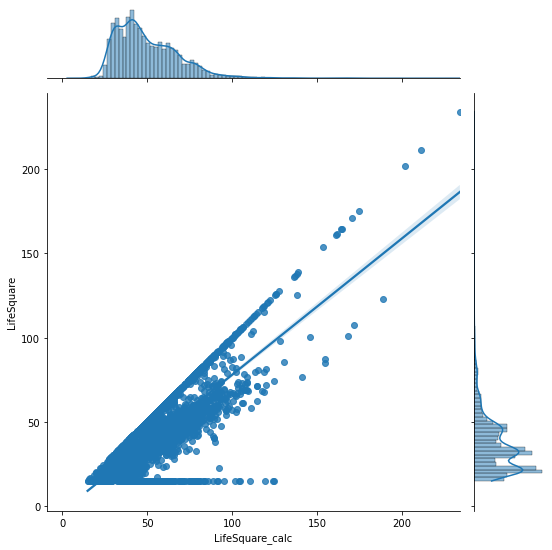

In [23]:
df_train['LifeSquare_calc'] = df_train['Square'] - df_train['KitchenSquare']
print('Corr coef is', df_train['LifeSquare'].corr(df_train['LifeSquare_calc']))

grid = sns.jointplot(df_train['LifeSquare_calc'], df_train['LifeSquare'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

Коэффициент корреляции составляет ~ 0.86 (включая уже проведенные синтетические расчеты), что можно считать достаточно высоким показателем. Воспользуемся указанным выше методом. Все изменения отображены в `null_handling()` ниже

Так как у признака `Healthcare_1` достаточно большой процент отсутствующих значений, заменить все на статическую величину будет не самой хорошей идеей.

In [24]:
feature = pd.qcut(df_train['Healthcare_1'], q=10)
group_by_feature(feature, dropna=False)

Healthcare_1 Price                                               \
                    count         median           mean            std   
0   (-0.001, 125.0]   591  193535.135764  218868.326914   95342.696300   
1    (125.0, 240.0]   526  233889.562575  254578.974725   92780.758552   
2    (240.0, 540.0]   799  182072.611955  196925.354191   78759.119719   
3    (540.0, 645.0]   188  233233.919416  263460.073938  118811.085909   
4    (645.0, 900.0]   512  199262.532145  227162.325371   97681.551445   
5   (900.0, 1084.0]   627  179421.544007  201049.943021   95987.631017   
6  (1084.0, 1340.0]   445  193036.568150  213637.011638   71907.992086   
7  (1340.0, 1937.0]   481  193741.172966  217409.385130   84347.782103   
8  (1937.0, 2643.0]   526  230357.279119  256920.444537  103452.920519   
9  (2643.0, 4849.0]   507  231360.118743  266870.766200  118455.952418   

  median dif, % mean dif, %     std, %  
                                        
0      0.658185    2.208599  44.523772  
1     21.646640   18.884997  43.327381  
2     -5.303506   -8.038477  36.779462  
3     21.305638   23.032353  55.483198  
4      3.637021    6.081786  45.615986  
5     -6.682335   -6.112349  44.824948  
6      0.398879   -0.234355  33.580076  
7      0.765346    1.527293  39.389293  
8     19.809489   19.978433  48.311139  
9     20.331069   24.625100  55.317355

Четко выделяющейся группы или серии групп, куда бы можно было отнести неопределенные значения, нет. Можно попробовать предугадать их:

In [25]:
def null_handling(origin_df, train_df=False):
    """
    Обработка null значений
    """
    delete_Price = False
    if type(train_df) == bool:
        train_df = origin_df
        delete_Price = True
    train_df['LifeSquare_calc'] = train_df['Square'] - train_df['KitchenSquare']
    life_sq_coef = train_df['LifeSquare'][train_df['LifeSquare'].isnull() != True].sum()\
                   / train_df['LifeSquare_calc'][train_df['LifeSquare'].isnull() != True].sum()
    origin_df.loc[origin_df['LifeSquare'].isnull(), 'LifeSquare'] = (origin_df['Square'] - origin_df['KitchenSquare']) \
                                                                    * life_sq_coef
    train_df.drop('LifeSquare_calc', axis=1, inplace=True)
    
    X_train = train_df.drop(['Healthcare_1', 'Id', 'Price'], axis=1).loc[train_df['Healthcare_1'].notna()]
    X_test = origin_df.drop(['Healthcare_1', 'Id'], axis=1).loc[origin_df['Healthcare_1'].isna()]
    if delete_Price:
        X_test.drop('Price', axis=1, inplace=True)
    y_train = train_df.loc[train_df['Healthcare_1'].notna(), 'Healthcare_1']

    model = RandomForestRegressor(n_estimators=100, max_depth=4, max_features=5)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    origin_df.loc[origin_df['Healthcare_1'].isna(), 'Healthcare_1'] = y_pred
    
    return origin_df

df_train = null_handling(df_train)

И немного оптимизируем выборку по занимаемому месту

In [26]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [27]:
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.47 MB
Decreased by 69.4%


### 1.5 Поиск новых признаков<a id='1.5'>
    
[Оглавление](#main)

Достоверно не знаем о смысле признаков социальных, здравоохранительных и серии признаков Shops, однако можно предположить, что признаки в одной категория имеют одинаковый посыл (если все увеличиваются, то это или только плохо, или только хорошо), поэтому их можно попробовать объединить:

In [28]:
df_train['Healthcare_all'] = (df_train['Healthcare_1'] - df_train['Healthcare_1'].mean()) / df_train['Healthcare_1'].mean()\
                            + (df_train['Helthcare_2'] - df_train['Helthcare_2'].mean()) / df_train['Helthcare_2'].mean()
df_train['Social_all'] = (df_train['Social_1'] - df_train['Social_1'].mean()) / df_train['Social_1'].mean()\
                        + (df_train['Social_2'] - df_train['Social_2'].mean()) / df_train['Social_2'].mean()\
                        + (df_train['Social_3'] - df_train['Social_3'].mean()) / df_train['Social_3'].mean()
df_train['Shops_all'] = (df_train['Shops_1'] - df_train['Shops_1'].mean()) / df_train['Shops_1'].mean()\
                        + (df_train['Shops_2'] - df_train['Shops_2'].mean()) / df_train['Shops_2'].mean()

Создадим ряд признаков, завязанных на расположении объекта

In [29]:
group_by_district = df_train.groupby('DistrictId').agg({'DistrictId':['count'],
                                                        'Square': ['mean'],
                                                        'Rooms': ['mean'],
                                                        'Price':['mean']})
group_by_district.columns = np.array(["_".join(x) for x in group_by_district.columns.ravel()])
group_by_district = group_by_district.reset_index()
group_by_district.columns = ['DistrictId', 'Dist_density', 'Sq_by_Dist', 'Rooms_by_Dist', 'Price_by_Dist']
group_by_district['Sq_for_room_by_Dist'] = group_by_district['Sq_by_Dist'] / group_by_district['Rooms_by_Dist']
group_by_district['Price_for_meter_by_Dist'] = group_by_district['Price_by_Dist'] / group_by_district['Sq_by_Dist']
group_by_district.drop('Price_by_Dist', axis=1, inplace=True)
group_by_district.head(5)

,DistrictId,Dist_density,Sq_by_Dist,Rooms_by_Dist,Sq_for_room_by_Dist,Price_for_meter_by_Dist
0,0,48,54.777763,1.770833,30.933325,3565.234863
1,1,652,60.168991,1.805215,33.330654,3121.298828
2,2,78,54.003201,1.910256,28.270132,4512.484863
3,3,82,50.249428,1.756098,28.614258,3580.239990
4,4,11,67.046951,2.363636,28.366018,4475.918457


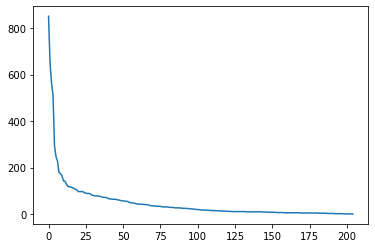

In [30]:
plt.plot(np.arange(group_by_district['DistrictId'].size), group_by_district['Dist_density'].sort_values(ascending=False))
plt.show()

Есть много районов, где число продаваемых квартир меньше 120, также это число является переломной точкой, где распределение резко меняет свой характер. Поэтом уразделим выборку на 2 соответствующих части

In [31]:
group_by_district['is_large_Dist'] = (group_by_district['Dist_density'] > 120).astype(int)
group_by_district.head(5)

,DistrictId,Dist_density,Sq_by_Dist,Rooms_by_Dist,Sq_for_room_by_Dist,Price_for_meter_by_Dist,is_large_Dist
0,0,48,54.777763,1.770833,30.933325,3565.234863,0
1,1,652,60.168991,1.805215,33.330654,3121.298828,1
2,2,78,54.003201,1.910256,28.270132,4512.484863,0
3,3,82,50.249428,1.756098,28.614258,3580.239990,0
4,4,11,67.046951,2.363636,28.366018,4475.918457,0


Также группируем по району и количеству комнта в продаваемой квартире и узнаем медианную цену предложений 

In [32]:
price_by_dist_room_cnt = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                        .rename(columns={'Price':'Price_by_Dist_Rooms'})
price_by_dist_room_cnt.head(5)

,DistrictId,Rooms,Price_by_Dist_Rooms
0,0,1.0,142799.437500
1,0,2.0,176210.812500
2,0,3.0,300610.375000
3,1,1.0,146735.671875
4,1,2.0,202666.312500


Также частично можно перенести измерения выше на распределение по этажу

In [33]:
group_by_floor = df_train.groupby('Floor').agg({'DistrictId':['count'],
                                                        'Square': ['mean'],
                                                        'Rooms': ['mean'],
                                                        'Price':['mean']})
group_by_floor.columns = np.array(["_".join(x) for x in group_by_floor.columns.ravel()])
group_by_floor = group_by_floor.reset_index()
group_by_floor.columns = ['Floor', 'Floor_density', 'Sq_by_Floor', 'Rooms_by_Floor', 'Price_by_Floor']
group_by_floor['Sq_for_room_by_Floor'] = group_by_floor['Sq_by_Floor'] / group_by_floor['Rooms_by_Floor']
group_by_floor['Price_for_meter_by_Floor'] = group_by_floor['Price_by_Floor'] / group_by_floor['Sq_by_Floor']
group_by_floor.drop('Price_by_Floor', axis=1, inplace=True)
group_by_floor.head()

,Floor,Floor_density,Sq_by_Floor,Rooms_by_Floor,Sq_for_room_by_Floor,Price_for_meter_by_Floor
0,1,235,54.436604,1.863830,29.206854,3328.589844
1,2,588,55.782757,1.904762,29.285948,3586.314697
2,3,872,54.721031,1.888762,28.971910,3601.148438
3,4,955,55.932449,1.935079,28.904486,3704.729492
4,5,876,54.359936,1.875571,28.983143,3838.159424


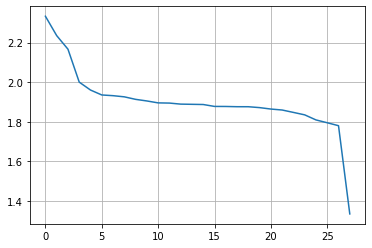

In [34]:
plt.plot(np.arange(group_by_floor['Floor'].size), group_by_floor['Rooms_by_Floor'].sort_values(ascending=False))
plt.grid()
plt.show()

Большая часть равномерного распредлеления квартир по числу комнат лежит в диапазоне от 1.75 до 2. Выдлеим их в группу

In [35]:
group_by_floor['is_standart_Rooms_cnt'] = (group_by_floor['Rooms_by_Floor'].between(1.75, 2.0)).astype(int)
group_by_floor.head()

,Floor,Floor_density,Sq_by_Floor,Rooms_by_Floor,Sq_for_room_by_Floor,Price_for_meter_by_Floor,is_standart_Rooms_cnt
0,1,235,54.436604,1.863830,29.206854,3328.589844,1
1,2,588,55.782757,1.904762,29.285948,3586.314697,1
2,3,872,54.721031,1.888762,28.971910,3601.148438,1
3,4,955,55.932449,1.935079,28.904486,3704.729492,1
4,5,876,54.359936,1.875571,28.983143,3838.159424,1


In [36]:
df_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Healthcare_all,Social_all,Shops_all
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,1144.814575,0,11,1,184966.937500,-0.905093,0.448929,1.689592
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,10309,1,240.000000,1,16,1,300009.437500,-1.012600,0.913859,2.871262
2,4765,53,2.0,44.947952,29.197611,3.0,8,12.0,1968,0.049637,...,7759,0,229.000000,1,3,1,220925.906250,-1.023120,-0.173061,-0.201080
3,5809,58,2.0,61.731510,52.731510,9.0,8,17.0,1993,0.437885,...,5735,3,1084.000000,0,5,1,175616.234375,-0.963256,-0.623634,0.271588
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2078.000000,2,4,1,150226.531250,1.503137,-0.378668,0.035254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401787,30.476204,5.0,6,32.0,1968,0.135650,...,7960,6,350.000000,3,11,1,196684.312500,0.608330,1.096923,1.689592
9996,6159,18,1.0,41.521545,20.539215,9.0,13,13.0,2000,0.000000,...,5562,0,770.645264,0,5,0,189050.296875,-1.262951,-0.745578,-0.818330
9997,5123,27,1.0,47.939007,33.617668,3.0,12,16.0,2015,0.072158,...,629,1,515.809143,0,0,0,159143.812500,-1.506677,-2.677073,-2.000000
9998,5400,75,2.0,43.602562,33.840149,8.0,1,5.0,1961,0.307467,...,5048,9,325.000000,2,5,1,181595.343750,-0.173443,0.277900,0.271588


In [37]:
def new_features_creating(origin_df, train_df=False):
    """
    Создание новых признаков и перенос в выборку
    """
    if type(train_df) == bool:
        train_df = origin_df
    
    origin_df['Healthcare_all'] = (origin_df['Healthcare_1'] - origin_df['Healthcare_1'].mean()) / origin_df['Healthcare_1'].mean()\
                                + (origin_df['Helthcare_2'] - origin_df['Helthcare_2'].mean()) / origin_df['Helthcare_2'].mean()
    origin_df['Social_all'] = (origin_df['Social_1'] - origin_df['Social_1'].mean()) / origin_df['Social_1'].mean()\
                            + (origin_df['Social_2'] - origin_df['Social_2'].mean()) / origin_df['Social_2'].mean()\
                            + (origin_df['Social_3'] - origin_df['Social_3'].mean()) / origin_df['Social_3'].mean()
    origin_df['Shops_all'] = (origin_df['Shops_1'] - origin_df['Shops_1'].mean()) / origin_df['Shops_1'].mean()\
                            + (origin_df['Shops_2'] - origin_df['Shops_2'].mean()) / origin_df['Shops_2'].mean()
    
    group_by_district = train_df.groupby('DistrictId').agg({'DistrictId':['count'],
                                                            'Square': ['mean'],
                                                            'Rooms': ['mean'],
                                                            'Price':['mean']})
    group_by_district.columns = np.array(["_".join(x) for x in group_by_district.columns.ravel()])
    group_by_district = group_by_district.reset_index()
    group_by_district.columns = ['DistrictId', 'Dist_density', 'Sq_by_Dist', 'Rooms_by_Dist', 'Price_by_Dist']
    group_by_district['Sq_for_room_by_Dist'] = group_by_district['Sq_by_Dist'] / group_by_district['Rooms_by_Dist']
    group_by_district['Price_for_meter_by_Dist'] = group_by_district['Price_by_Dist'] / group_by_district['Sq_by_Dist']
    group_by_district.drop('Price_by_Dist', axis=1, inplace=True)
    group_by_district['is_large_Dist'] = (group_by_district['Dist_density'] > 120).astype(int)
    
    price_by_dist_room_cnt = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'Price_by_Dist_Rooms'})
    price_by_dist_room_cnt.head(5)
    
    group_by_floor = train_df.groupby('Floor').agg({'DistrictId':['count'],
                                                    'Square': ['mean'],
                                                    'Rooms': ['mean'],
                                                    'Price':['mean']})
    group_by_floor.columns = np.array(["_".join(x) for x in group_by_floor.columns.ravel()])
    group_by_floor = group_by_floor.reset_index()
    group_by_floor.columns = ['Floor', 'Floor_density', 'Sq_by_Floor', 'Rooms_by_Floor', 'Price_by_Floor']
    group_by_floor['Sq_for_room_by_Floor'] = group_by_floor['Sq_by_Floor'] / group_by_floor['Rooms_by_Floor']
    group_by_floor['Price_for_meter_by_Floor'] = group_by_floor['Price_by_Floor'] / group_by_floor['Sq_by_Floor']
    group_by_floor.drop('Price_by_Floor', axis=1, inplace=True)
    group_by_floor['is_standart_Rooms_cnt'] = (group_by_floor['Rooms_by_Floor'].between(1.75, 2.0)).astype(int)
    
    
    origin_df = origin_df.merge(group_by_district, on=['DistrictId'], how='left')
    origin_df = origin_df.merge(price_by_dist_room_cnt, on=['DistrictId', 'Rooms'], how='left')
    origin_df = origin_df.merge(group_by_floor, on=['Floor'], how='left')
    
    origin_df[['DistrictId', 'Id']] = origin_df[['DistrictId', 'Id']].astype(str)
    
    origin_df['LifeSq_to_KitchenSq_relation'] = origin_df['KitchenSquare'] / origin_df['LifeSquare']
    
    return origin_df

df_train = new_features_creating(df_train)

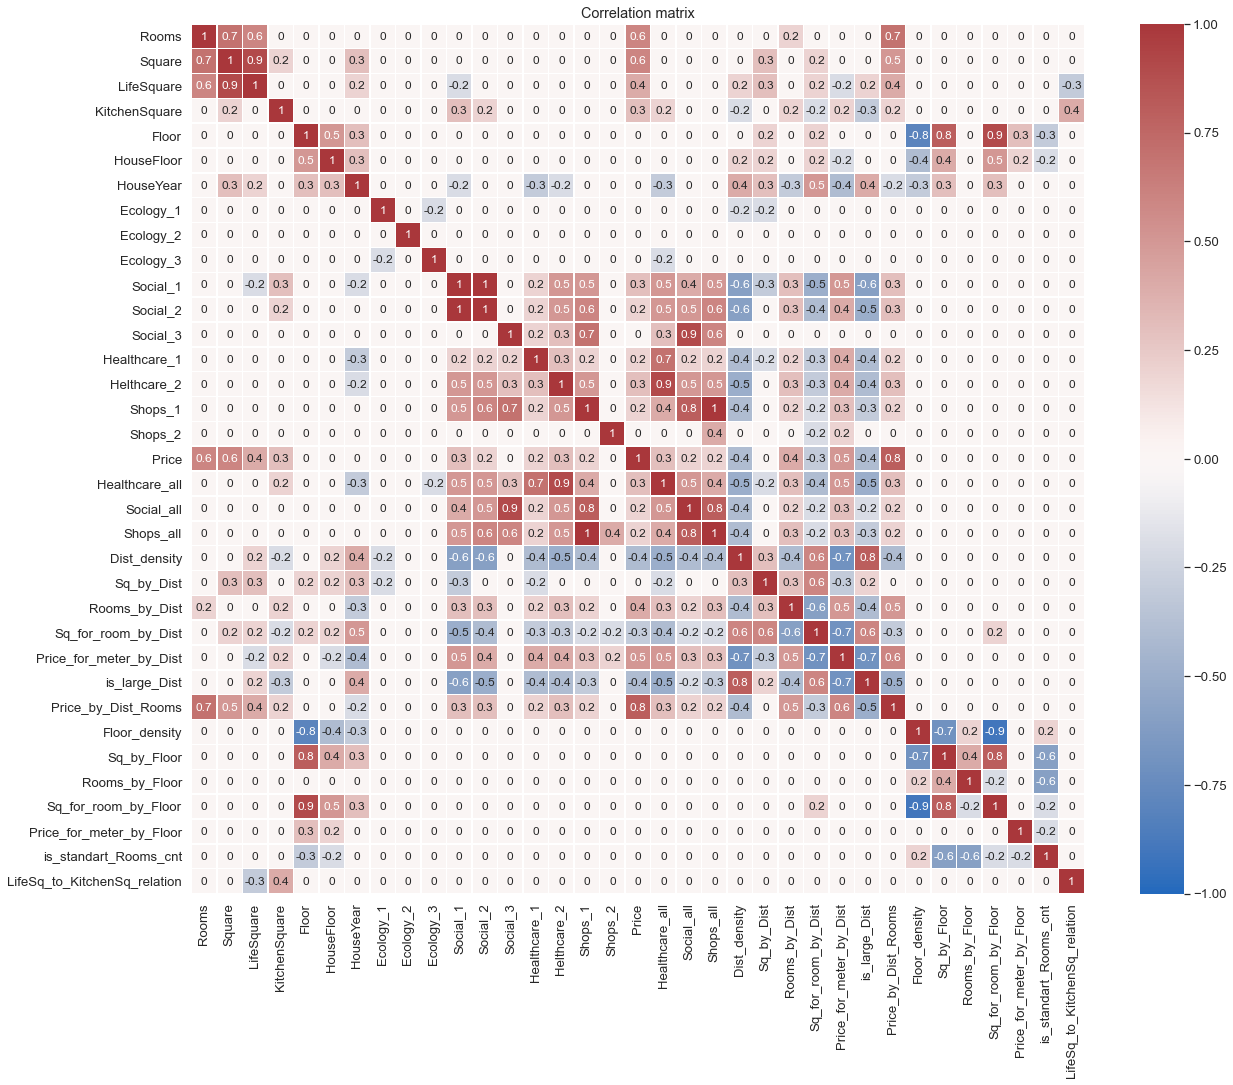

In [38]:
plt.figure(figsize = (20,16))

sns.set(font_scale=1.2)

corr_matrix = df_train.corr()
corr_matrix[np.abs(corr_matrix) < 0.15] = 0
corr_matrix = np.round(corr_matrix, 1)

sns.heatmap(corr_matrix, annot=True, linewidths=0.5, vmin=-1, vmax=1, cmap='vlag', annot_kws={"size":12})

plt.title('Correlation matrix')
plt.show()

Объединим все ранее созданные методы для обработки тестовой выборки

In [39]:
def data_transform(origin_df, train_df=False):
    """
    Полностью подготавливает данные для предсказания
    """
    if type(train_df) == bool:
        train_df = origin_df.copy()
    
    origin_df = outliers_handling(origin_df, train_df)
    train_df = outliers_handling(train_df)
    
    origin_df = category_transform(origin_df)
    train_df = category_transform(train_df)
    
    origin_df = value_correction(origin_df)
    train_df = value_correction(train_df)
    
    train_df = null_handling(train_df)
    origin_df = null_handling(origin_df, train_df)
    
    origin_df = new_features_creating(origin_df, train_df)
    train_df = new_features_creating(train_df)
    
    na_cloumns = origin_df.columns[origin_df.isnull().sum() > 0]
    for column in na_cloumns:
        origin_df.loc[origin_df[column].isna(), column] = train_df[column].median()
    
    return origin_df

### 2. Построение модели<a id='2'> </a>
    
[Оглавление](#main)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(columns=['Price', 'Id']), df_train.Price, test_size=0.33, random_state=13)

model = GradientBoostingRegressor(n_estimators=300, max_depth=3, max_features=15, learning_rate=0.03, random_state=13)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [41]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    # Честно украденная функция, потому что понравилась

    """
    print("Train R2:\t" + str(round(r2_score(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2_score(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.plot(train_true_values, train_true_values)
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.plot(test_true_values, test_true_values)
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Train R2:	0.796
Test R2:	0.752


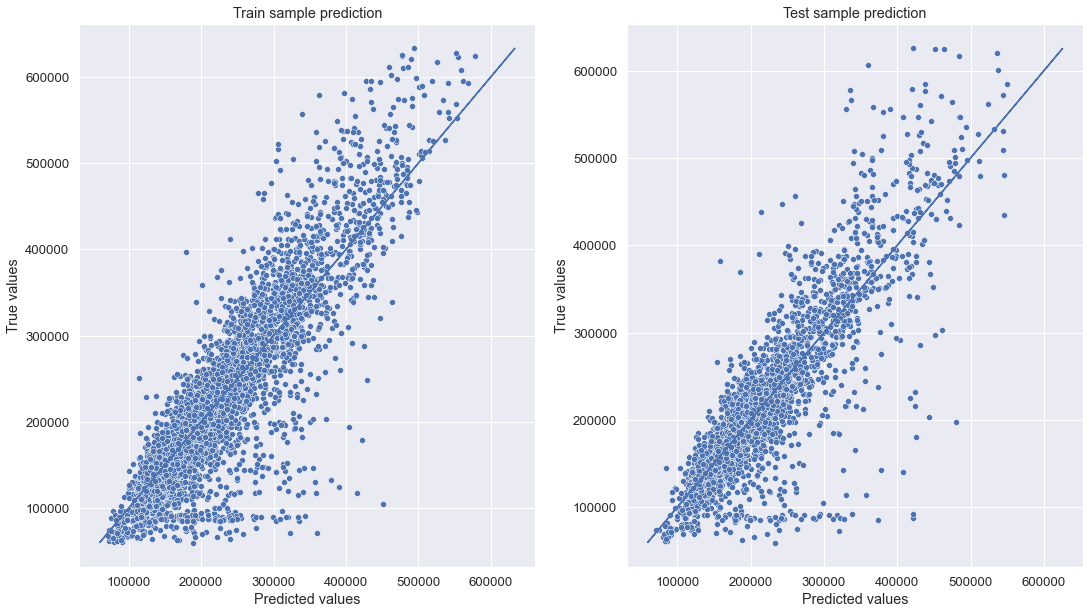

,feature_name,importance
27,Price_by_Dist_Rooms,0.342247
2,Square,0.245621
25,Price_for_meter_by_Dist,0.128591
1,Rooms,0.058938
3,LifeSquare,0.052387
21,Dist_density,0.031503
19,Social_all,0.019372
26,is_large_Dist,0.016733
4,KitchenSquare,0.016346
7,HouseYear,0.015729


In [42]:
evaluate_preds(y_train, y_pred_train, y_test, y_pred)
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False).nlargest(20, 'importance')

In [43]:
df_for_predict = data_transform(df_for_predict, pd.read_csv(for_model_csv))
'Количество null записей в test выборке: ' + str(df_for_predict.isna().sum().sum())

'Количество null записей в test выборке: 0'

In [44]:
y_pred_test = model.predict(df_for_predict.drop('Id', axis=1))

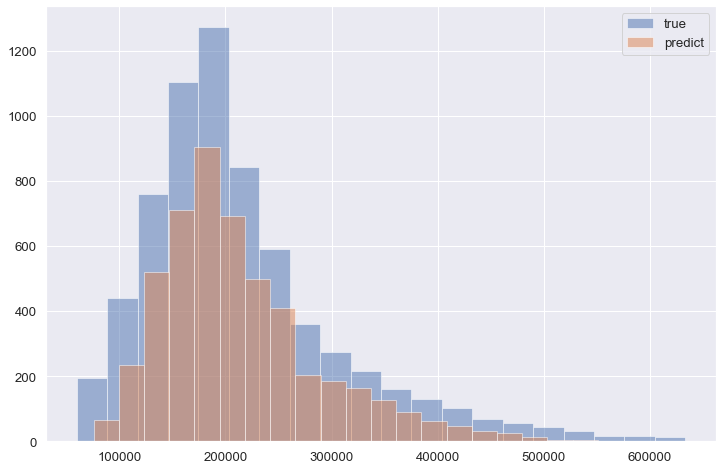

In [45]:
plt.figure(figsize = (12,8))
plt.hist(y_train, bins=20, label='true', alpha=0.5)
plt.hist(y_pred_test, bins=20, label='predict', alpha=0.5)
plt.legend(loc='best')

plt.show()

In [46]:
df_pred = pd.DataFrame(y_pred_test, columns=['Price'])

In [47]:
df_pred.to_csv('AIGladkov_predictions.csv', index_label='Id')